# FLAT model - input file preparation

### Import modules and libraries

In [1]:
import geopandas as gpd
import rasterio as rio
import fiona
import gdal
import osr
import ogr
import rasterio.mask
import time
import os
import ogr, gdal, osr, os
import numpy as np
import itertools
import re
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
from rasterstats import point_query
from pyproj import Proj

### Processing steps

1. Set filepath names - inputs and outputs
2. Read raster, shp data, reproject and resample
3. Clip data to country boundaries
4. Vectorize and extract centroids at target spatial resolution
5. Extract raster values to points

In [2]:
def reproj(inpath, outpath, new_crs, factor):
    dst_crs = new_crs

    with rio.open(inpath) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width*factor, src.height*factor, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(outpath, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)

### Step 1. Set filepath names - inputs and outputs

In [3]:
#start = time.time()
%time

# Set output filepath
fp = r"C:\Users\alekor\Desktop\GithubFolder\agrodem\FLAT_data_preparation\Output_Files"

# Set initial raster file (Harvest choice 10x10km) path
hcData = r"C:\Users\alekor\Desktop\GithubFolder\agrodem\FLAT_data_preparation\Input_Files\maiz_h--ssa\maiz_h--ssa.tif"

# Set output raster file name (only projected)
hcData_proj = "maize_proj.tif"

# Set output raster file name (projected + resampled)
hcData_proj_res = "maize_proj_1km.tif"

# Set country boundaries (shp) path
country_fp = r"C:\Users\alekor\Desktop\GithubFolder\agrodem\FLAT_data_preparation\Input_Files\gadm36_MOZ_shp\gadm36_MOZ_0.shp"

# Set projected country boundaries file name  ? - I get an error otherwise, look below.
country_proj = "MOZ_0_proj.shp"

# Set country, crop output raster file name (1km)
maize_MOZ = "maize_MOZ_1km.tif"

# Set country, crop vectorized data
maize_MOZ_vec = "maize_MOZ_vec.shp"

# Set country, crop vector centroids - points
maize_MOZ_points = "maize_MOZ_points.shp"

# Set country, crop points with maize area (final)
maize_MOZ_grid_cell_1km = "maize_MOZ_grid_cell_1km.shp"

# Set final table (csv) path
maize_MOZ_data = "maize_MOZ_data.csv"

Wall time: 0 ns


### Step 2. Read and re-projects crop raster and admin shp layers

Wall time: 0 ns


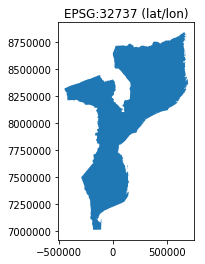

In [10]:
#Read initial raster file (HarvestChoice 10x10km^2) - Reproject, resample, and save.
#CRS for Mozambique EPSG:32737 - WGS 84 / UTM zone 37S
%time

reproj(inpath = hcData,
       outpath = fp + "\\" + hcData_proj_res,
       new_crs = 'EPSG:32737',
       factor = 10)


# Read country boundaries outline - Reproject and save.
mozambique  = gpd.read_file(country_fp)
mozambique_proj = mozambique.to_crs({'init': 'EPSG:32737'})

# Save file 
mozambique_proj.to_file(fp + "\\" + country_proj)

#Print output map (optional)
ax = mozambique_proj.plot()
ax.set_title("EPSG:32737 (lat/lon)");

### Step 3. Clip data to country boundaries

In [12]:
# Crop raster data to country boundaries - and export.
%time

with fiona.open(fp + "\\" + country_proj) as shapefile:
    features = [feature["geometry"] for feature in shapefile]


with rio.open(fp + "\\" + hcData_proj_res) as src:
    out_image, out_transform = rio.mask.mask(src, features,
                                                        crop=True)
    out_meta = src.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rio.open(fp + maize_MOZ, "w", **out_meta) as dest:
    dest.write(out_image)

Wall time: 0 ns


### Step 4. Vectorize and extract centroids at target resolution

In [16]:
%time 
import ogr, gdal, osr, os
import numpy as np
import itertools

def pixelOffset2coord(raster, xOffset,yOffset):
    geotransform = raster.GetGeoTransform()
    originX = geotransform[0]
    originY = geotransform[3]
    pixelWidth = geotransform[1]
    pixelHeight = geotransform[5]
    coordX = originX+pixelWidth*xOffset
    coordY = originY+pixelHeight*yOffset
    return coordX, coordY

def raster2array(rasterfn):
    raster = gdal.Open(rasterfn)
    band = raster.GetRasterBand(1)
    array = band.ReadAsArray()
    return array

def array2shp(array,outSHPfn,rasterfn):

    # max distance between points
    raster = gdal.Open(rasterfn)
    geotransform = raster.GetGeoTransform()
    pixelWidth = geotransform[1]

    srs = osr.SpatialReference()
    srs.ImportFromWkt(raster.GetProjection())
    
    # wkbPoint
    shpDriver = ogr.GetDriverByName("ESRI Shapefile")
    if os.path.exists(outSHPfn):
        shpDriver.DeleteDataSource(outSHPfn)
    outDataSource = shpDriver.CreateDataSource(outSHPfn)
    outLayer = outDataSource.CreateLayer(outSHPfn, geom_type=ogr.wkbPoint, srs=srs )
    featureDefn = outLayer.GetLayerDefn()
    outLayer.CreateField(ogr.FieldDefn("VALUE", ogr.OFTInteger))

    # array2dict
    point = ogr.Geometry(ogr.wkbPoint)
    row_count = array.shape[0]
    for ridx, row in enumerate(array):
        if ridx % 100 == 0:
            print ("{0} of {1} rows processed".format(ridx, row_count))
        for cidx, value in enumerate(row):
            #Only positive values
            if value > 0:
                Xcoord, Ycoord = pixelOffset2coord(raster,cidx,ridx)
                point.AddPoint(Xcoord, Ycoord)
                outFeature = ogr.Feature(featureDefn)
                outFeature.SetGeometry(point)
                outFeature.SetField("VALUE", float(value))
                outLayer.CreateFeature(outFeature)
                outFeature.Destroy()
    #outDS.Destroy()

array = raster2array(fp + maize_MOZ)
array2shp(array,fp + maize_MOZ_points,fp + maize_MOZ)

Wall time: 0 ns
0 of 1825 rows processed
100 of 1825 rows processed
200 of 1825 rows processed
300 of 1825 rows processed
400 of 1825 rows processed
500 of 1825 rows processed
600 of 1825 rows processed
700 of 1825 rows processed
800 of 1825 rows processed
900 of 1825 rows processed
1000 of 1825 rows processed
1100 of 1825 rows processed
1200 of 1825 rows processed
1300 of 1825 rows processed
1400 of 1825 rows processed
1500 of 1825 rows processed
1600 of 1825 rows processed
1700 of 1825 rows processed
1800 of 1825 rows processed


### Step 5. Extract layer values to points

#### Harvest Choice (without resampling)

In [21]:
%time

reproj(inpath = hcData,
       outpath = fp + hcData_proj,
       new_crs = 'EPSG:32737',
       factor = 1)

# Reminder
#stats = zonal_stats(fp + maize_MOZ_vec, fp + hcData_proj)
#pts = point_query(fp + maize_MOZ_points, fp + hcData_proj)

print ("Extracting " + hcData_proj+ " values to points...")
data = gpd.read_file(fp + maize_MOZ_points)
data['maize_h_HC'] = point_query(fp + maize_MOZ_points, fp + hcData_proj)

Wall time: 0 ns
Extracting maize_proj.tif values to points...


#### Google Earth Engine data 

- NDVI
- EVI
- Elevation
- Slope

In [22]:
%time 

# Define the path of GEE features 
gee_path_proj = r"C:\Users\alekor\Desktop\GithubFolder\agrodem\FLAT_data_preparation\Input_Files\gee_data"

gee_files_proj=[]

print ("Reading GEE data...")


for i in os.listdir(gee_path_proj):
    if i.endswith('.tif'):
        gee_files_proj.append(i)


for i in gee_files_proj:
    print ("Extracting " + i + " values to points...")    
    idx = i.index(".tif")
    #print(i[:idx])
    data[i[:idx]] = point_query(fp + maize_MOZ_points, gee_path_proj + i)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 6.91 µs
Reading GEE data...
Extracting GFSAD-landcover.tif values to points...
GFSAD-landcover
Extracting SRTM-elevation.tif values to points...
SRTM-elevation
Extracting MODIS-ndvi.tif values to points...
MODIS-ndvi
Extracting SRTM-slope.tif values to points...
SRTM-slope
Extracting MODIS-evi.tif values to points...
MODIS-evi


#### Climatic Parameters (WorldClimV2)

In [11]:
#Monthly variation - January selected for pilot testing
worldClim_path = r"C:\Users\alekor\Desktop\GithubFolder\agrodem\FLAT_data_preparation\Input_Files\worldclim_data"
worldClim_path_proj = r"C:\Users\alekor\Desktop\GithubFolder\agrodem\FLAT_data_preparation\Input_Files\worldclim_data\wc_reproj"

worldClim_files=[]
worldClim_files_proj=[]

print ("Reading climate data...")

for i in os.listdir(worldClim_path):
    if i.endswith('.tif'):
        worldClim_files.append(i)

for i in worldClim_files:
    print ("Reprojecting..." + i)
    idx = i.index(".tif")
    reproj(inpath=worldClim_path + i,
           outpath=worldClim_path_proj + i[:idx] + "_proj" +i[idx:] ,
           new_crs='EPSG:32737',
           factor=1)
    
for i in os.listdir(worldClim_path_proj):
    if i.endswith('.tif'):
        worldClim_files_proj.append(i)

for i in worldClim_files_proj:
    with rio.open(worldClim_path_proj + i) as src:
        out_image, out_transform = rio.mask.mask(src, features,crop=True)
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

    with rio.open(worldClim_path_proj + i, "w", **out_meta) as dest:
        dest.write(out_image)
    
    print (i+ " was clipped to Zambezia's boundaries...")
    
    substr = re.findall("_[a-z]{4}_", i)
    columName = substr[0].replace("_","")
    print ("Extracting " + columName + " values to points...")
    data[columName] = point_query(fp + maize_MOZ_points, worldClim_path_proj + i)

%time 

Reading climate data...
Reprojecting...wc2.0_30s_srad_01.tif
Reprojecting...wc2.0_30s_prec_01.tif
Reprojecting...wc2.0_30s_tavg_01.tif
Reprojecting...wc2.0_30s_wind_01.tif
wc2.0_30s_wind_01_proj.tif was clipped to Zambezia's boundaries...
Extracting wind values to points...
wc2.0_30s_prec_01_proj.tif was clipped to Zambezia's boundaries...
Extracting prec values to points...
wc2.0_30s_srad_01_proj.tif was clipped to Zambezia's boundaries...
Extracting srad values to points...
wc2.0_30s_tavg_01_proj.tif was clipped to Zambezia's boundaries...
Extracting tavg values to points...
CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


#### Soil Parameters (AfricaSoilGrids)

In [13]:
#sample input parameters
%time

soilGrids_path = r"C:\Users\alekor\Desktop\GithubFolder\agrodem\FLAT_data_preparation\Input_Files\africaSoil"
soilGrids_path_proj = r"C:\Users\alekor\Desktop\GithubFolder\agrodem\FLAT_data_preparation\Input_Files\africaSoil\afg_reproj"

soilGrid_files = []
soilGrid_files_proj = []

print ("Reading soil data...")

# for i in os.listdir(soilGrids_path):
#     if i.endswith('.tif'):
#         soilGrid_files.append(i)

# for i in soilGrid_files:
#     print ("Reprojecting..." + i)
#     idx = i.index(".")
#     reproj(inpath=soilGrids_path + i,
#            outpath=soilGrids_path_proj + i[:idx] + "_proj" +i[idx:] ,
#            new_crs='EPSG:32737',
#            factor=1)

for i in os.listdir(soilGrids_path_proj):
    if i.endswith('.tif'):
        soilGrid_files_proj.append(i)

for i in soilGrid_files_proj:
    with rio.open(soilGrids_path_proj + i) as src:
        out_image, out_transform = rio.mask.mask(src, features,crop=True)
        out_meta = src.meta.copy()
        out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

    with rio.open(soilGrids_path_proj + i, "w", **out_meta) as dest:
        dest.write(out_image)
    
    print (i+ "was clipped to Zambezia's boundaries...")
    substr = re.findall("_(.+?)_", i)
    columName = substr[0]
    print ("Extracting " + columName + " values to points...")
    data[columName] = point_query(fp + maize_MOZ_points, soilGrids_path_proj + i)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
Reading soil data...
af_CLYPPT_T__M_sd1_250m_proj.tifwas clipped to Zambezia's boundaries...
Extracting CLYPPT values to points...
af_BLD_T__M_sd1_250m_proj.tifwas clipped to Zambezia's boundaries...
Extracting BLD values to points...
SRTM_W_250m_proj.tifwas clipped to Zambezia's boundaries...
Extracting W values to points...
af_PHIHOX_T__M_sd1_250m_proj.tifwas clipped to Zambezia's boundaries...
Extracting PHIHOX values to points...
af_ORCDRC_T__M_sd1_250m_proj.tifwas clipped to Zambezia's boundaries...
Extracting ORCDRC values to points...
SRTM_SE_250m_proj.tifwas clipped to Zambezia's boundaries...
Extracting SE values to points...
af_DRAINFAO_T__M_250m_proj.tifwas clipped to Zambezia's boundaries...
Extracting DRAINFAO values to points...
af_TEXMHT_T__M_sd1_250m_proj.tifwas clipped to Zambezia's boundaries...
Extracting TEXMHT values to points...
af_BDRICM_T__M_250m_proj.tifwas clipped to Zambezia's boundaries...
Extra

#### Elevation & slope (in case retrieved separately and not from gee)

In [ ]:
#%time
#
#elevation_path = r"..."
#elevation_path_proj = r"..."
#
#elev = "SRTM_SE_250m.tif"
#elev_proj = "SRTM_SE_250m_proj.tif"
#
#print ("Reprojecting..." + elev)
#reproj(inpath = elevation_path + elev,
#       outpath = elevation_path_proj + elev_proj,
#       new_crs = 'EPSG:32737',
#       factor = 1)
#
#with rio.open(elevation_path_proj + elev_proj) as src:
#        out_image, out_transform = rio.mask.mask(src, features,crop=True)
#        out_meta = src.meta.copy()
#        out_meta.update({"driver": "GTiff",
#                 "height": out_image.shape[1],
#                 "width": out_image.shape[2],
#                 "transform": out_transform})
#
#with rio.open(elevation_path_proj + elev_proj, "w", **out_meta) as dest:
#    dest.write(out_image)
#
#data['elev'] = point_query(fp + maize_MOZ_points, elevation_path_proj + elev_proj)
#
#data.to_file(fp + "data_GEE_WorldClim_SoilGrids_Elev.shp")

#### Assign Latitude and Longitude

In [28]:
df = data

df = data.drop('geometry', axis=1)
df = df.drop('W', axis=1)
#df.rename(columns={'lon': 'lonUTM', 'lat': 'latUTM'}, inplace=True)
df['lonUTM'] = data.geometry.apply(lambda p: p.x)
df['latUTM'] = data.geometry.apply(lambda p: p.y)
MOZproj = Proj("+proj=utm +zone=37 +south +datum=WGS84 +units=m +no_defs")
lon,lat = MOZproj(df['lonUTM'].values, df['latUTM'].values, inverse=True)
df['lon'] = lon
df['lat'] = lat

df.head()

,VALUE,maize_h_HC,GFSAD-landcover,SRTM-elevation,MODIS-ndvi,SRTM-slope,MODIS-evi,wind,prec,srad,...,PHIHOX,ORCDRC,SE,DRAINFAO,TEXMHT,BDRICM,lonUTM,latUTM,lon,lat
0,258,126.923392,1.330109,853.264944,6403.687307,11.310229,3277.329986,1.490595,277.006256,17265.677162,...,57.065534,21.764265,889.049186,5.000000,6.171849,158.906195,302771.334302,8.340833e+06,37.165714,-15.000218
1,258,147.563392,1.330109,1081.022003,6507.347361,15.854384,3219.560671,1.402846,287.391491,17288.555725,...,56.182518,20.292910,1183.493908,5.000000,6.000000,164.728645,303775.740244,8.340833e+06,37.175051,-15.000293
2,258,168.203392,1.330109,1455.425572,6263.906239,16.701038,2949.530051,1.490357,296.133216,17236.699826,...,55.090051,26.057395,1414.669793,5.000000,6.000000,141.050570,304780.146186,8.340833e+06,37.184389,-15.000368
3,258,188.843392,1.330109,1522.134653,6568.908992,15.792265,3456.843417,1.662432,304.491258,17160.786020,...,52.000000,51.000000,1742.000000,5.000000,6.000000,132.000000,305784.552128,8.340833e+06,37.193727,-15.000442
4,258,142.788816,0.000000,756.989975,5827.661548,7.969555,3167.059946,1.310524,265.000326,17410.273620,...,57.877183,16.366192,748.575918,5.931281,8.819163,137.557869,302771.334302,8.339828e+06,37.165636,-15.009295


In [29]:
#Print NA values in dataset 
#df.isna().sum()

#Set NA values equal to 0
#df = df.fillna(0)

VALUE                 0
maize_h_HC         1879
GFSAD-landcover       0
SRTM-elevation        0
MODIS-ndvi            6
SRTM-slope           82
MODIS-evi             4
wind                302
prec                302
srad                302
tavg                302
CLYPPT              431
BLD                 431
PHIHOX              431
ORCDRC              431
SE                  267
DRAINFAO            431
TEXMHT              431
BDRICM              431
lonUTM                0
latUTM                0
lon                   0
lat                   0
dtype: int64

### Export datarame to csv file

In [30]:
path = r"C:\Users\alekor\Desktop\GithubFolder\agrodem\FLAT_data_preparation\Output_Files\Output_to_FLAT"
df.to_csv(os.path.join(path,"{c}.csv".format(c="FLAT_Input_Data")))